In [143]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import random
import string

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
df = read_run_dir(run_dir)
# df  # list all the runs in our run_dir

In [145]:
task = "seq_relu_2nn"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"
# task = "linear_regression"

# run_id = "84d6d60f-ec2f-4dff-a947-3a0bbc668579"  # if you train more models, replace with the run_id from the table above
# run_id = "first-successful"
# run_id = "e522e868-6238-436b-bb3e-f4655c8b8ee5"
run_id = "863d2e34-7d95-4b06-b05e-dc39e4fb22c6"

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = True

if recompute_metrics:
    # question: is this with the test set? -- i think so
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

100%|██████████| 15/15 [00:00<00:00, 180788.97it/s]


In [146]:
def save_current_figure(folder_path, file_name):
    if not os.path.exists("plots"):
        os.makedirs("plots")
    folder_path = "plots/" + folder_path
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    file_path = os.path.join(folder_path, file_name)
    plt.savefig(file_path)
    plt.close()

def generate_random_string(length=8):
    letters_and_digits = string.ascii_letters + string.digits
    random_string = ''.join(random.choice(letters_and_digits) for _ in range(length))
    return random_string

In [147]:
fig_output_dir = run_id + "_" + task + "_" + generate_random_string()

# Plot pre-computed metrics

linear_regression_toy first-successful


100%|██████████| 15/15 [00:00<00:00, 80350.65it/s]


metrics: {'standard': {'gpt2_embd=256_layer=12_head=8': {'mean': [4.621098518371582, 4.208076477050781, 3.008338451385498, 2.149143695831299, 1.472686767578125, 0.8162189722061157, 0.5938932299613953, 0.4458659589290619, 0.3081079423427582, 0.2671031951904297, 0.22850556671619415], 'std': [8.05871868133545, 7.773054122924805, 5.9312310218811035, 4.4603590965271, 3.6566274166107178, 1.8779603242874146, 1.7604429721832275, 1.2636525630950928, 0.820002019405365, 0.8433252573013306, 0.4301208555698395], 'bootstrap_low': [4.248167991638184, 3.865124464035034, 2.735055446624756, 1.9417860507965088, 1.307705283164978, 0.7336638569831848, 0.5123953819274902, 0.3887562155723572, 0.27433714270591736, 0.23061791062355042, 0.20852208137512207], 'bootstrap_high': [5.009133338928223, 4.580620765686035, 3.3075790405273438, 2.350036382675171, 1.6406772136688232, 0.9020301699638367, 0.6683294177055359, 0.50965815782547, 0.3463234305381775, 0.3071441054344177, 0.24873247742652893]}, 'OLS_driver=None': {

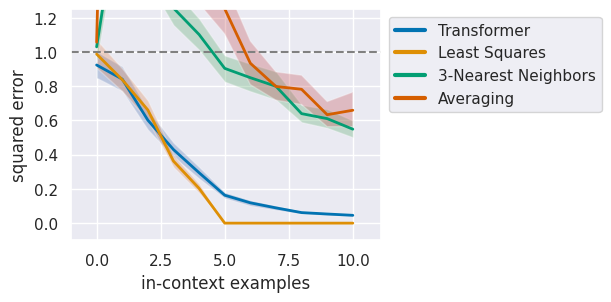

In [148]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()
save_current_figure(fig_output_dir, "eval_on_all_models")

{'Transformer': {'mean': [0.9301206588745117, 0.4837796688079834, 0.126284921169281, 0.046257758140563966, 0.032778921723365786, 0.023133985698223114, 0.025617757439613344, 0.026077356934547425, 0.023506948351860048, 0.02998559772968292, 0.023008720576763154], 'std': [2.295123481750488, 1.170039463043213, 0.4704094409942627, 0.1751772165298462, 0.1487213373184204, 0.060163193941116334, 0.07118877172470092, 0.07917722463607788, 0.1345655918121338, 0.23710134029388427, 0.09803065061569213], 'bootstrap_low': [0.8306795120239258, 0.43071441650390624, 0.10491588115692138, 0.03864151835441589, 0.026774898171424866, 0.02047512084245682, 0.022372917830944063, 0.022679996490478516, 0.018546876311302186, 0.020803001523017884, 0.019054034352302553], 'bootstrap_high': [1.0478567123413085, 0.5339232444763183, 0.1499232292175293, 0.05453150868415833, 0.040242737531661986, 0.02589797377586365, 0.028859677910804748, 0.02969498038291931, 0.03025587499141693, 0.04257191717624664, 0.027652105689048766]},

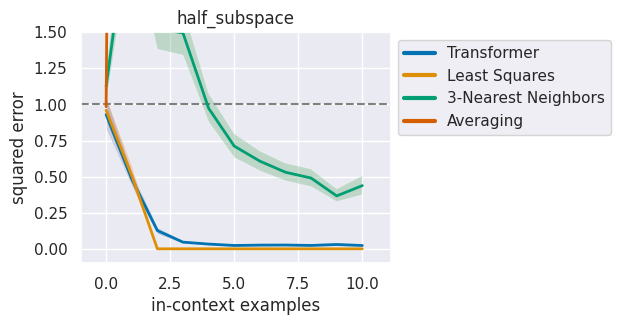

{'Transformer': {'mean': [0.9584826469421387, 0.9292290687561036, 0.8242879867553711, 0.72708158493042, 0.7717054843902588, 0.619357681274414, 0.5537896156311035, 0.532089376449585, 0.47528829574584963, 0.4227332592010498, 0.39288983345031736], 'std': [1.4965293884277344, 1.6204105377197267, 1.444085693359375, 1.1514209747314452, 1.6521678924560548, 1.2305586814880372, 0.9028656959533692, 0.8574790000915528, 0.7990457534790039, 0.7326409816741943, 0.6167187690734863], 'bootstrap_low': [0.8911249160766601, 0.8567182540893554, 0.7564933776855469, 0.676054859161377, 0.6978408813476562, 0.566275691986084, 0.5133513450622559, 0.4915008068084717, 0.43654594421386717, 0.3894432544708252, 0.36562333106994627], 'bootstrap_high': [1.0305431365966797, 1.0103535652160645, 0.8874094009399414, 0.780137014389038, 0.8492477416992188, 0.6782793998718262, 0.5960483551025391, 0.574141550064087, 0.5120977401733399, 0.46004395484924315, 0.4215129852294922]}, 'Least Squares': {'mean': [1.0090934753417968, 0

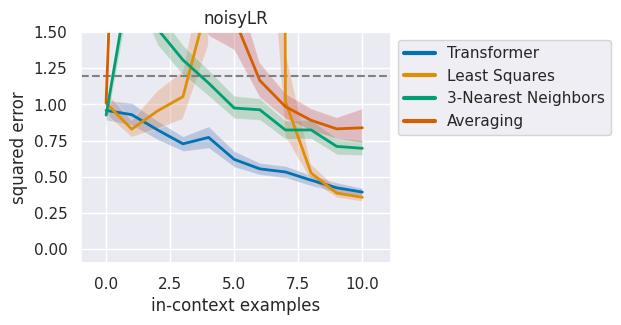

{'Transformer': {'mean': [1.0122471809387208, 1.028064250946045, 1.0204133987426758, 1.0568167686462402, 0.9861870765686035, 0.005912937596440316, 0.0060680128633975984, 0.0054597102105617525, 0.005213659256696701, 0.005595657974481583, 0.013512644171714782], 'std': [1.7219022750854491, 1.8740686416625976, 1.9674032211303711, 1.817169189453125, 1.6689487457275392, 0.010200943052768707, 0.010237655788660049, 0.009061922878026962, 0.009378978610038757, 0.008913972973823547, 0.021043528616428376], 'bootstrap_low': [0.9315690994262695, 0.9375231742858887, 0.9362750053405762, 0.9746623992919922, 0.908414077758789, 0.005447403341531753, 0.005592871829867363, 0.0050484083592891695, 0.004794620722532272, 0.005207138508558274, 0.012575574219226837], 'bootstrap_high': [1.0942480087280273, 1.116153621673584, 1.1167219161987305, 1.1468937873840332, 1.067514705657959, 0.006424900144338608, 0.006537187844514847, 0.005904123932123184, 0.005663217976689339, 0.006044149398803711, 0.014477565884590149]}

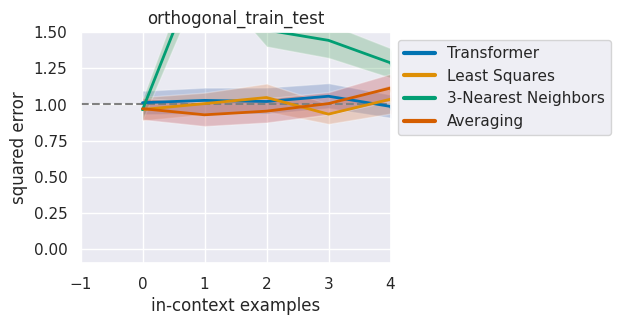

{'Transformer': {'mean': [1.0591511726379395, 0.0219392865896225, 0.029762089252471924, 0.02880128026008606, 0.030334681272506714, 0.028768420219421387, 0.0287119060754776, 0.02680048644542694, 0.025342291593551634, 0.0321728527545929, 0.0349007785320282], 'std': [1.9301902770996093, 0.08106029629707337, 0.057205593585968016, 0.06761420965194702, 0.08553427457809448, 0.061810141801834105, 0.054080229997634885, 0.07562060356140136, 0.07331997752189637, 0.10039687156677246, 0.08809314966201783], 'bootstrap_low': [0.9720884323120117, 0.01840372085571289, 0.027256095409393312, 0.0259207159280777, 0.02678360939025879, 0.026140829920768736, 0.026304525136947633, 0.02361864745616913, 0.022126491367816924, 0.02779889702796936, 0.030763524770736694], 'bootstrap_high': [1.144071674346924, 0.025737786293029787, 0.03218786716461182, 0.0321455329656601, 0.03438530564308166, 0.03141435980796814, 0.031325578689575195, 0.03047821521759033, 0.029004353284835815, 0.03694767057895661, 0.03906350433826446

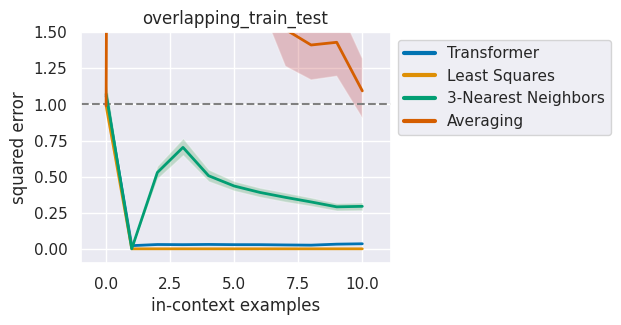

{'Transformer': {'mean': [0.9949466705322265, 0.7981341361999512, 0.578551959991455, 0.45754098892211914, 0.33510603904724123, 0.23114871978759766, 0.2184507131576538, 0.16869068145751953, 0.13266552686691285, 0.11153408288955688, 0.11431692838668824], 'std': [1.7412799835205077, 1.3920302391052246, 1.2485844612121582, 0.970641803741455, 0.635891342163086, 0.514271879196167, 0.49173436164855955, 0.38494608402252195, 0.30978372097015383, 0.23704767227172852, 0.3419440746307373], 'bootstrap_low': [0.9104562759399414, 0.7336718082427979, 0.5254038333892822, 0.4127923011779785, 0.3064413070678711, 0.20641987323760985, 0.19581705331802368, 0.15116620063781738, 0.11927073001861573, 0.10087981224060058, 0.09879797697067261], 'bootstrap_high': [1.0795315742492675, 0.8633400917053222, 0.6419396877288819, 0.5045822143554688, 0.363885235786438, 0.25625762939453123, 0.24133496284484862, 0.18650219440460206, 0.1460122585296631, 0.12348741292953491, 0.13026340007781984]}, 'Least Squares': {'mean': [

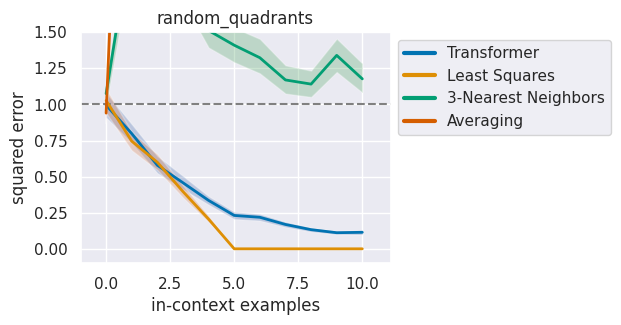

{'Transformer': {'mean': [0.11093717813491821, 0.08785538673400879, 0.07587129473686219, 0.05802382230758667, 0.0440303236246109, 0.032147324085235594, 0.023803701996803282, 0.0161863774061203, 0.015491624176502228, 0.013448138535022736, 0.014092913269996643], 'std': [0.22065460681915283, 0.1680272102355957, 0.14971858263015747, 0.12652926445007323, 0.09713373184204102, 0.06573767066001893, 0.062267130613327025, 0.032953661680221555, 0.052337038516998294, 0.035340675711631776, 0.027360895276069643], 'bootstrap_low': [0.10173715353012085, 0.08034484982490539, 0.0691706657409668, 0.05227451324462891, 0.03974201083183289, 0.02908322513103485, 0.020992326736450195, 0.01470043659210205, 0.013127818703651428, 0.011993378400802612, 0.01278938353061676], 'bootstrap_high': [0.12251732349395753, 0.09548616409301758, 0.08344635963439942, 0.06410847306251526, 0.04860835075378418, 0.035180875658988954, 0.02692555487155914, 0.01769641786813736, 0.01822095364332199, 0.015178677439689637, 0.0153993993

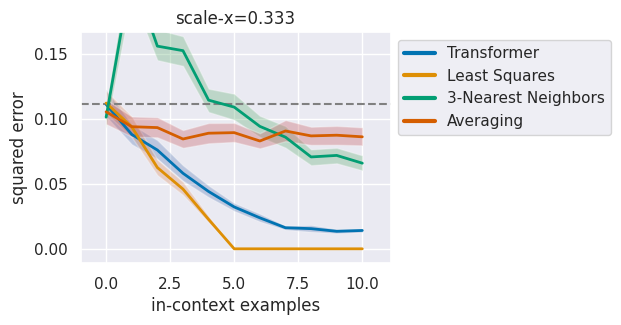

{'Transformer': {'mean': [0.2581474781036377, 0.21811048984527587, 0.15992707014083862, 0.11015056371688843, 0.07291043996810913, 0.058144760131835935, 0.03437014520168304, 0.026460415124893187, 0.02386263906955719, 0.018691954016685487, 0.018393144011497498], 'std': [0.4496821403503418, 0.36764702796936033, 0.290626072883606, 0.22866978645324706, 0.1577460289001465, 0.17325229644775392, 0.0818827748298645, 0.0652194619178772, 0.0772979736328125, 0.04449301660060882, 0.037451863288879395], 'bootstrap_low': [0.23821229934692384, 0.20180599689483641, 0.1464332103729248, 0.09915092587471008, 0.06589684486389161, 0.050513970851898196, 0.03089902400970459, 0.023690299689769746, 0.02049109637737274, 0.016732773184776305, 0.016788049042224883], 'bootstrap_high': [0.2788150072097778, 0.23579936027526854, 0.17352581024169922, 0.12107384204864502, 0.0800207018852234, 0.06590031385421753, 0.03835707902908325, 0.029525190591812134, 0.0274915874004364, 0.020744633674621583, 0.020250356197357176]}, 

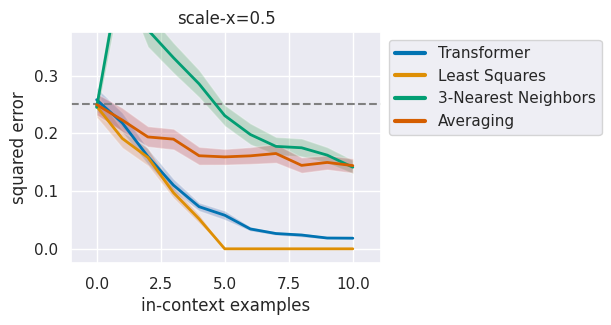

{'Transformer': {'mean': [4.132279586791992, 3.3665416717529295, 2.5118932723999023, 2.165744972229004, 1.4626928329467774, 1.19099760055542, 1.0181927680969238, 1.031261157989502, 0.9310773849487305, 0.8846813201904297, 0.9024500846862793], 'std': [7.402774810791016, 6.123593139648437, 4.815822601318359, 4.3540702819824215, 3.122266387939453, 2.6493106842041017, 2.2615737915039062, 2.284060478210449, 2.304939079284668, 2.0945873260498047, 2.237677574157715], 'bootstrap_low': [3.800386428833008, 3.0724767684936523, 2.286676597595215, 1.9747486114501953, 1.3216809272766112, 1.0660694122314454, 0.916234016418457, 0.9234579086303711, 0.8337263107299805, 0.7926315307617188, 0.7972832679748535], 'bootstrap_high': [4.516483306884766, 3.6640453338623047, 2.7472097396850588, 2.3746196746826174, 1.6100582122802733, 1.3175607681274415, 1.1185523986816406, 1.1405599594116211, 1.0369766235351563, 0.9765121459960937, 1.0067167282104492]}, 'Least Squares': {'mean': [3.9031543731689453, 3.04576606750

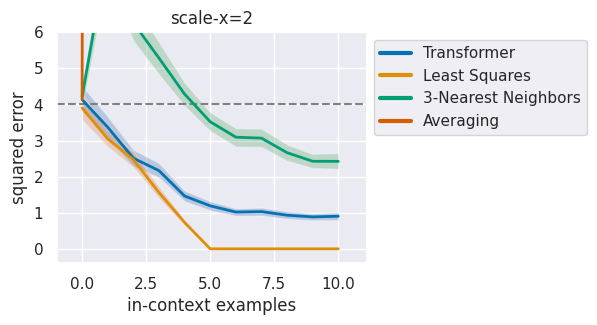

{'Transformer': {'mean': [9.457908630371094, 8.369343566894532, 6.40985107421875, 5.417805862426758, 5.096781539916992, 4.992509078979492, 4.668442916870117, 4.478287887573242, 4.692166519165039, 3.989904022216797, 4.901379013061524], 'std': [16.901974487304688, 16.523898315429687, 12.234098052978515, 10.300464630126953, 12.128523254394532, 10.946308135986328, 10.259111022949218, 10.034310150146485, 9.590608215332031, 7.915215301513672, 12.283319091796875], 'bootstrap_low': [8.65136260986328, 7.586595153808593, 5.824480056762695, 4.926718902587891, 4.575707244873047, 4.5424949645996096, 4.1969757080078125, 4.03296127319336, 4.2750701904296875, 3.641001510620117, 4.381905746459961], 'bootstrap_high': [10.276529693603516, 9.138375091552735, 6.997859954833984, 5.888591384887695, 5.667325592041015, 5.5636749267578125, 5.176774215698242, 4.972105407714844, 5.165824508666992, 4.32884635925293, 5.4656929016113285]}, 'Least Squares': {'mean': [8.818559265136718, 7.86771240234375, 5.57776718139

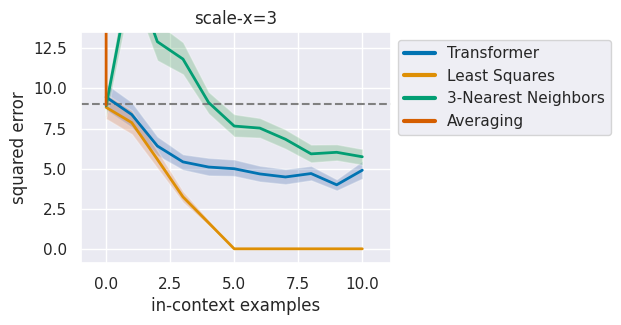

{'Transformer': {'mean': [0.11044665575027465, 0.08753690719604493, 0.07124919295310975, 0.0557688057422638, 0.04221872389316559, 0.02681790292263031, 0.020386822521686554, 0.016646933555603028, 0.015607607364654542, 0.012535664439201354, 0.012509068846702576], 'std': [0.17919243574142457, 0.16069155931472778, 0.13937534093856813, 0.1158594012260437, 0.09862552285194397, 0.05363937616348267, 0.047529613971710204, 0.03914705514907837, 0.03277477025985718, 0.027960458397865297, 0.027837485074996948], 'bootstrap_low': [0.10279619693756104, 0.08053385019302368, 0.06511808633804321, 0.05043659210205078, 0.037695693969726565, 0.024470333755016328, 0.01823238581418991, 0.014953188598155975, 0.014100387692451477, 0.0113397479057312, 0.011293862015008926], 'bootstrap_high': [0.11919645071029664, 0.09570051431655884, 0.07793599367141724, 0.06092814207077026, 0.04704089760780335, 0.02934221923351288, 0.02261787950992584, 0.018524834513664247, 0.017251409590244293, 0.014008411765098571, 0.01381020

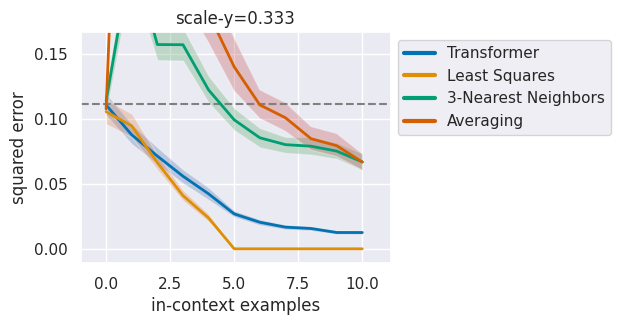

{'Transformer': {'mean': [0.2591949462890625, 0.20544023513793946, 0.16720221042633057, 0.10985149145126342, 0.07555769681930542, 0.05907983779907226, 0.03563738465309143, 0.027962613105773925, 0.021475031971931458, 0.019311672449111937, 0.016533401608467103], 'std': [0.47191762924194336, 0.35127317905426025, 0.34200899600982665, 0.23552608489990234, 0.16828782558441163, 0.1475146532058716, 0.08710848093032837, 0.09853636026382447, 0.058866721391677854, 0.046923473477363586, 0.03365797400474548], 'bootstrap_low': [0.23802952766418456, 0.18988122940063476, 0.1518460512161255, 0.09937210083007812, 0.06777833700180054, 0.05258198976516724, 0.03161948025226593, 0.023739762604236603, 0.018911783397197724, 0.017110219597816466, 0.014985111355781556], 'bootstrap_high': [0.28186931610107424, 0.22202823162078858, 0.18351094722747802, 0.12066953182220459, 0.08346701860427856, 0.06615663170814515, 0.03944804668426514, 0.0328632116317749, 0.02430805265903473, 0.021673476696014403, 0.01811641156673

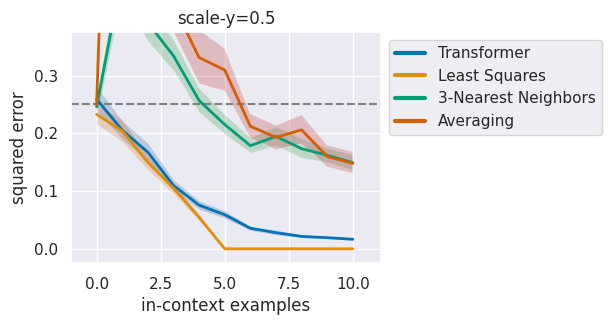

{'Transformer': {'mean': [3.7006900787353514, 3.153239440917969, 2.437790870666504, 2.0676271438598635, 1.3241018295288085, 1.0662437438964845, 0.8390065193176269, 0.688206958770752, 0.5499771118164063, 0.4793102264404297, 0.5076886653900147], 'std': [6.370274353027344, 6.250403976440429, 6.018246078491211, 4.503079605102539, 3.1675132751464843, 2.9604806900024414, 2.4579193115234377, 1.8961484909057618, 1.5840362548828124, 1.4972962379455566, 1.8977853775024414], 'bootstrap_low': [3.4195026397705077, 2.8955860137939453, 2.19772891998291, 1.8684762954711913, 1.1792760848999024, 0.9304826736450196, 0.7337336540222168, 0.6054856300354003, 0.47604937553405763, 0.4137763023376465, 0.4192197322845459], 'bootstrap_high': [3.9894332885742188, 3.4489646911621095, 2.7402454376220704, 2.2784292221069338, 1.4824941635131836, 1.203440284729004, 0.9526972770690918, 0.7774552822113037, 0.6192025661468505, 0.5504641532897949, 0.6012728214263916]}, 'Least Squares': {'mean': [3.978191375732422, 3.34388

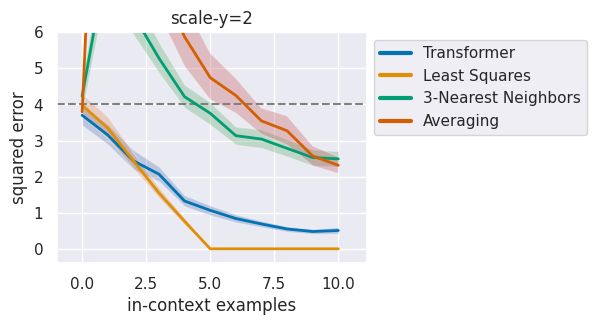

{'Transformer': {'mean': [9.505769348144531, 7.470295715332031, 6.436376953125, 4.781878662109375, 3.970943069458008, 3.7758106231689452, 3.2086219787597656, 3.066729736328125, 2.900491714477539, 2.734535789489746, 2.4267766952514647], 'std': [16.954795837402344, 12.5353759765625, 13.707095336914062, 9.268421173095703, 8.284069061279297, 9.666961669921875, 8.97530288696289, 8.850565338134766, 9.333296203613282, 7.3329925537109375, 6.4497802734375], 'bootstrap_low': [8.733560943603516, 6.833007049560547, 5.7897895812988285, 4.350960159301758, 3.6130794525146483, 3.366398239135742, 2.81363582611084, 2.6605981826782226, 2.4912899017333983, 2.4103200912475584, 2.144944953918457], 'bootstrap_high': [10.267170715332032, 8.011481475830077, 7.111817932128906, 5.189410400390625, 4.34935417175293, 4.249168014526367, 3.6530689239501952, 3.4635971069335936, 3.3420482635498048, 3.1192455291748047, 2.7296009063720703]}, 'Least Squares': {'mean': [8.89511947631836, 6.845304870605469, 5.99191513061523

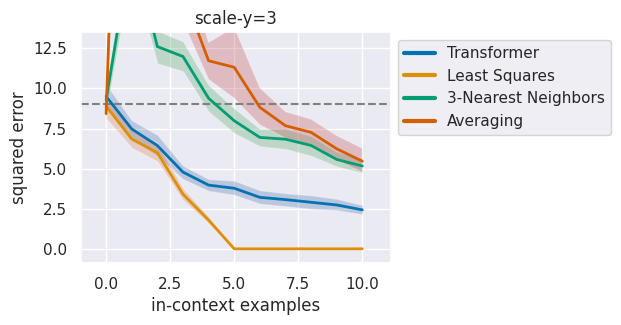

{'Transformer': {'mean': [1.012199878692627, 0.6188509464263916, 0.35566296577453616, 0.23437023162841797, 0.16333553791046143, 0.09225642085075378, 0.07928568124771118, 0.06485495567321778, 0.05708351731300354, 0.05030556321144104, 0.05207959413528442], 'std': [2.2507015228271485, 1.4346991539001466, 0.8025230407714844, 0.49398303031921387, 0.41349363327026367, 0.23611879348754883, 0.35920095443725586, 0.1684965133666992, 0.14087945222854614, 0.1471466302871704, 0.21531639099121094], 'bootstrap_low': [0.9217086791992187, 0.5560332775115967, 0.3186615467071533, 0.21290361881256104, 0.14504430294036866, 0.08239022493362427, 0.06572559475898743, 0.057621484994888304, 0.05089219212532044, 0.04423302114009857, 0.043321818113327026], 'bootstrap_high': [1.1186545372009278, 0.6853465080261231, 0.39397368431091306, 0.2591767072677612, 0.18377997875213622, 0.10395176410675049, 0.09796296954154968, 0.07335389852523803, 0.06397814750671386, 0.05727313160896301, 0.06184185743331909]}, 'Least Squar

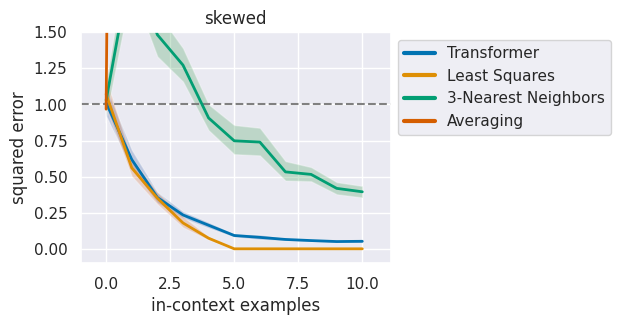

In [149]:
# plot any OOD metrics, out of distribution
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()
    if ("." in name):
        name = name.replace(".", "")
    save_current_figure(fig_output_dir, "eval_on_all_models_ood_" + name)

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [150]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [151]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [152]:
def generate_random_ys(num_changes, num_total, b_dim, y_dim=0):
    """
    Selects num_changes random indices from the range 0 to num_total - 1.

    Args:
    - num_total (int): Total number of indices.
    - num_changes (int): Number of random indices to select.
    - b_dim (int): Dimension of a batch
    - y_dim (int): Dimension of y

    Returns:
    - torch.Tensor: Tensor containing the selected random indices. batch size x num changes 
    - torch.Tensor: Tensor containing the new random values at those indices
    """

    if num_changes > num_total:
        raise ValueError("Number of changes cannot be greater than the total number.")
    
    # Generate random indices

    if (y_dim == 0):
        random_indices = torch.randint(0, num_total, (b_dim, num_changes), dtype=torch.long)
        indices_values = torch.rand((b_dim, num_changes))
    else: 
        random_indices = torch.randint(0, num_total, (b_dim, num_changes), dtype=torch.long)
        indices_values = torch.rand((b_dim, num_changes, y_dim))

    return random_indices, indices_values

In [153]:
SEQ = "seq" in task

In [154]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)

if not SEQ:
    ys = task.evaluate(xs)
    y_dim = 0
else: 
    xs, ys = task.generate_sequence(xs[:, 0, :], conf.model.n_positions)
    y_dim = ys.shape[2]

num_indices = [i for i in range(1, conf.model.n_positions)]
randomized_ys_array = []

for num_changes in num_indices:
    randomized_ys = ys.clone()
    random_indices, indices_values = generate_random_ys(num_changes, randomized_ys.shape[1], randomized_ys.shape[0], y_dim)

    for b in range(randomized_ys.shape[0]):
        randomized_ys[b][random_indices[b]] = indices_values[b]

    randomized_ys_array.append(randomized_ys)

In [155]:
with torch.no_grad():
    pred = model(xs, ys)

pred = pred.squeeze()

# if not SEQ:
randomized_pred_array = []
for randomized_ys in randomized_ys_array:
    with torch.no_grad():
        randomized_pred = model(xs, randomized_ys)
    randomized_pred = randomized_pred.squeeze()
    randomized_pred_array.append(randomized_pred)
    

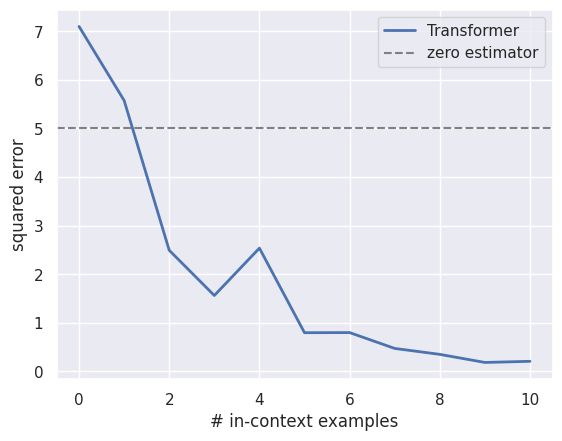

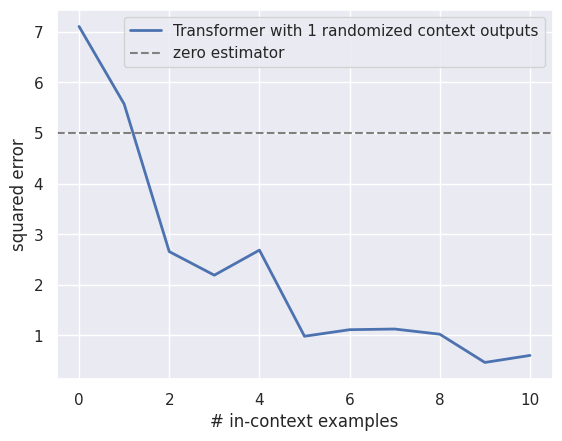

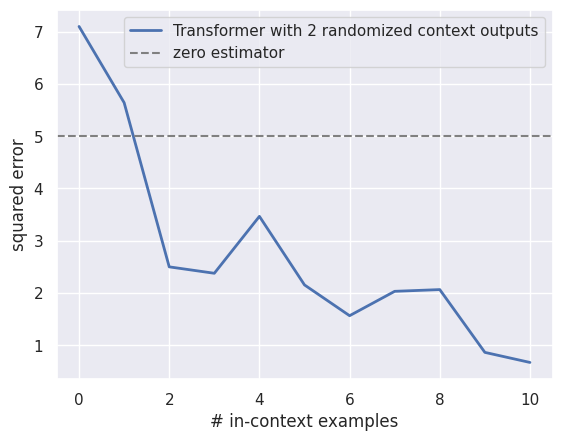

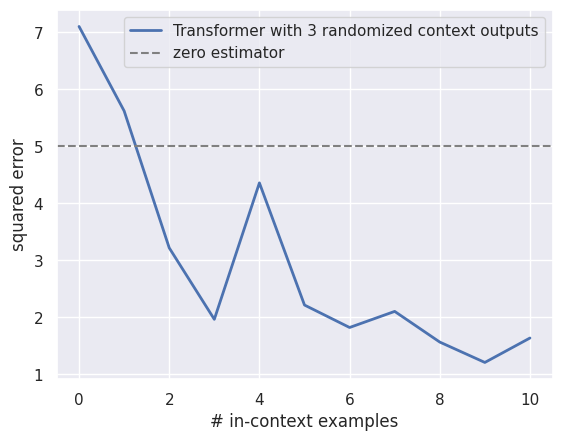

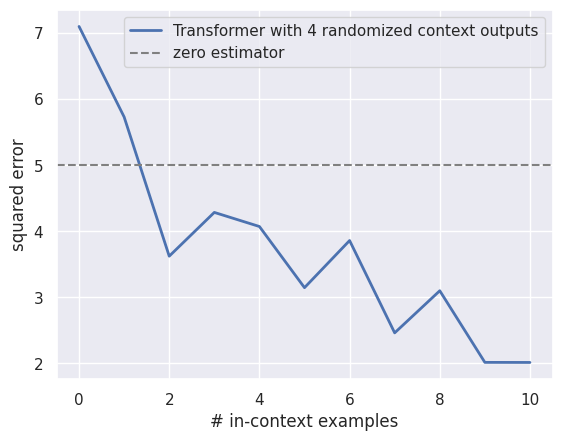

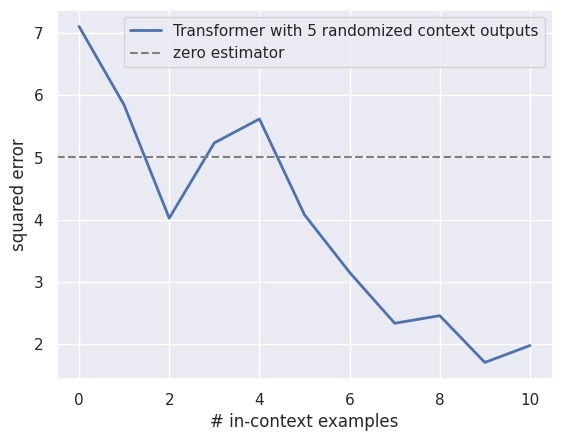

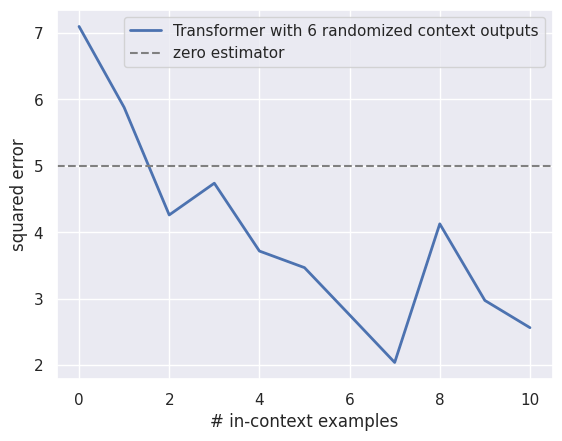

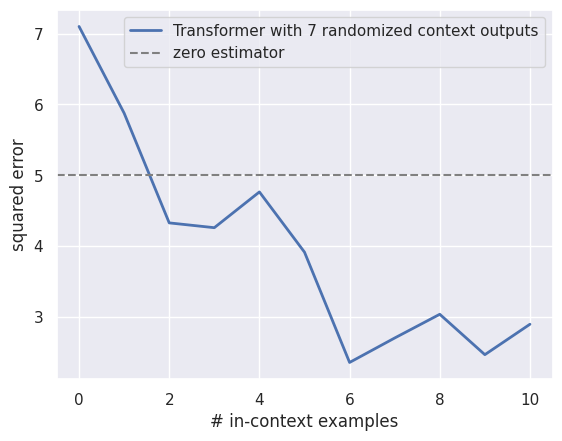

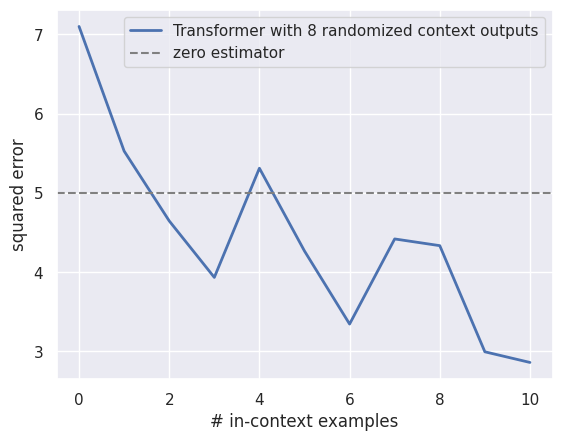

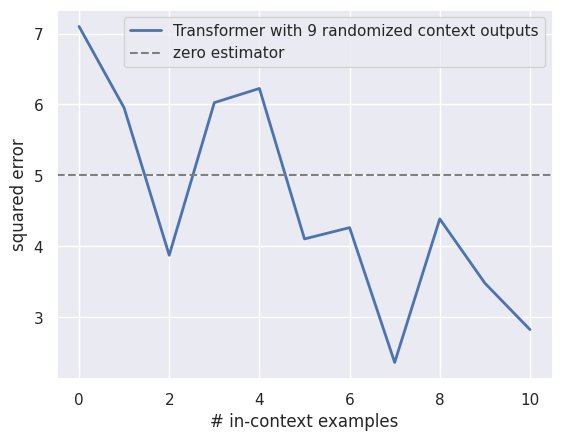

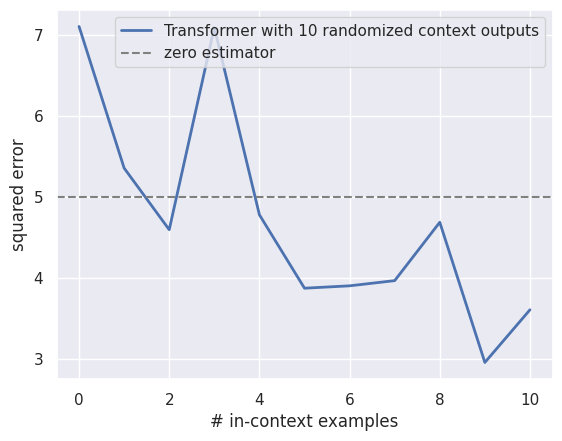

In [156]:
# it seems like the metric is just subtracting the predictions from the ys, but im confused because are the ys not like passed in as context?
metric = task.get_metric()
loss = metric(pred, ys).numpy()
randomized_loss = metric(randomized_pred, ys).numpy()
# randomized_loss_w_random = metric(randomized_pred, randomized_ys).numpy()

# get eval accuracy
# print(ys[0][0])
# print(pred[0][0])
# print(torch.eq(ys, pred))

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
    "seq_relu_2nn": n_dims
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()
save_current_figure(fig_output_dir, "eval_on_transformer")

# if (not SEQ):
num_random = 1

for randomized_pred in randomized_pred_array:
    randomized_loss = metric(randomized_pred, ys).numpy()
    
    plt.plot(randomized_loss.mean(axis=0), lw=2, label="Transformer with " + str(num_random) +  " randomized context outputs")
    plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
    plt.xlabel("# in-context examples")
    plt.ylabel("squared error")
    plt.legend()
    plt.show()
    save_current_figure(fig_output_dir, "eval_on_transformer_" + str(num_random) + "_randomized_context")
    num_random += 1

        

# plt.plot(randomized_loss_w_random.mean(axis=0), lw=2, label="Transformer with randomized context")
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
# plt.xlabel("# in-context examples")
# plt.ylabel("squared error")
# plt.legend()
# plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [157]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)
pred2 = pred2.squeeze()

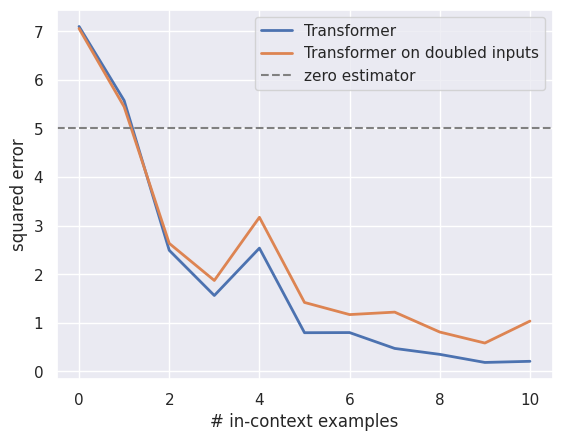

In [158]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()
save_current_figure(fig_output_dir, "eval_on_transformer_with_doubled_inputs")

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.